In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

In [15]:
class C_Node:

    def __init__(self):
        self.m_NodeIndx=-1
        self.m_Impurity=-1
        self.m_NodeDepth=-1
        self.m_ParentNodeIndx=-1
        self.m_LeftChildIndx=-1
        self.m_RightChildIndx=-1
        self.m_IsDecisionNode=None
        self.m_Label=-1
        self.m_Centroids=None
        self.m_DataLength=None
        
    def setNode(self,nodeIndx,nodeDepth,parentNodeIndx):  
        self.m_NodeIndx = nodeIndx
        self.m_NodeDepth = nodeDepth
        self.m_ParentNodeIndx = parentNodeIndx

        
class C_Tree:
    
    def __init__(self,maxDepth,maxNodeNum,path,dataNumThresh,impThresh,ImpDropThresh,method):
        self.m_MaxDepth = maxDepth
        self.m_MaxNodeNum = maxNodeNum
        self.m_CurrNodeNum = 0 
        self.m_NodeArray = [C_Node() for i in range(self.m_MaxNodeNum)]
        self.m_Path = path
        self.m_DataNumThresh = dataNumThresh
        self.m_ImpThresh = impThresh
        self.m_ImpDropThresh = ImpDropThresh
        self.m_Method = method
        
    def getImpurity(self,dataFileName):
        datalist = np.genfromtxt(dataFileName, delimiter=',')
        if (len(datalist.shape) == 1):
            return 0
        else:
            y=np.array([int(i) for i in datalist[:,-1]])
            label, label_count = np.unique(y, return_counts=True)
            label_prob = label_count/np.sum(label_count,dtype=np.float64)

            if self.m_Method==1:                                       ##Mis-classification Impurity
                if len(label_prob)==1:
                    imp = 0
                else:
                    imp = 1 - max(label_prob)

            if self.m_Method==2:                                        ##Gini Impurity
                imp = 1 - (np.sum(label_prob**2)) 

            if self.m_Method==3:                                        ##Entropy Impurity
                if (len(label_count)==0) :
                    imp = 0

                else:
                    imp = -1 * np.sum(np.array([p*np.log(p) for p in label_prob]))
            return(imp)
    
    def informationDrop(self,data_left,data_right):    
        filename1 = "LeftFile.csv"
        filename2 = "RightFile.csv"
        np.savetxt(filename1, data_left, delimiter = ",")
        np.savetxt(filename2, data_right, delimiter = ",")
        imp_left = self.getImpurity(filename1)
        imp_right = self.getImpurity(filename2)
        l = len(data_left)
        r = len(data_right)
        totalImp = (l*imp_left + r*imp_right)/(l+r)
        return totalImp

    def twoMeans(self,dataFileName):
        datalist = np.genfromtxt(dataFileName, delimiter=',')
        X = datalist[:,:datalist.shape[1]-1]
        y = np.array([int(i) for i in datalist[:,-1]])

        kmeans = KMeans(n_clusters=2).fit(X)
        centroids = kmeans.cluster_centers_
        cluster_labels = kmeans.labels_

        data_left=[]
        data_right=[]
        label, label_count = np.unique(cluster_labels, return_counts=True)
        for i in range(len(X)):
            if cluster_labels[i]==label[0]:
                data_left.append(datalist[i])
            if cluster_labels[i]==label[1]:
                data_right.append(datalist[i])     
        data_left=np.array(data_left)
        data_right=np.array(data_right)
        return data_left,data_right,centroids

    def decisionRule(self,x,node):
        mean1 = node.m_Centroids[0]
        mean2 = node.m_Centroids[1]
        dist1 = np.linalg.norm(x-mean1)
        dist2 = np.linalg.norm(x-mean2)
        if dist1 <= dist2:
            return 0
        else:
            return 1
    
    def splitDataFile(self,node_obj,data_left,data_right):  
        filename1 = self.m_Path+"/"+"d_"+str(node_obj.m_LeftChildIndx)+".csv"
        filename2 = self.m_Path+"/"+"d_"+str(node_obj.m_RightChildIndx)+".csv"
        os.makedirs(os.path.dirname(filename1), exist_ok=True)
        os.makedirs(os.path.dirname(filename2), exist_ok=True)
        np.savetxt(filename1, data_left, delimiter = ",")
        np.savetxt(filename2, data_right, delimiter = ",")                                               
    
    def checkTerminationCondition(self,node,datafilename):
        datalist = np.genfromtxt(datafilename, delimiter=',')
        if len(datalist.shape) == 1:
            IsDecisionNode = False
            dataLength = 1
            Label = datalist[-1]
            imp = 0
        else:    
            dataLength = datalist.shape[0]
            X = datalist[:,:-1]
            y = datalist[:,-1]
            label,label_count = np.unique(y,return_counts=True)
            imp = self.getImpurity(datafilename)

            data_left,data_right,centroids = self.twoMeans(datafilename)

            InformationGain = imp - self.informationDrop(data_left,data_right)
            
            if (dataLength<=self.m_DataNumThresh or imp<=self.m_ImpThresh or node.m_NodeDepth >= self.m_MaxDepth
                or InformationGain <= self.m_ImpDropThresh):        

                IsDecisionNode=False
                Label = label[np.argmax(label_count)]
            else:
                IsDecisionNode=True
                Label = None

        return IsDecisionNode,dataLength,Label,imp,data_left,data_right,centroids
        
    def printNodeData(self,node):
        print(str(node.m_NodeIndx)+"-----node index")
        print(str(node.m_Label)+"-------node Label")
        print(str(node.m_NodeDepth)+"------node Depth")
        print(str(node.m_DataLength)+"----- no. of datapoints")
        print(str(node.m_Impurity)+"-------- Impurity")
        if node.m_Label != None:
            print("This is a Leaf Node!")
        else:
            print("This is a Decision Node!")
        print("-------------------------")
        
    def fit(self,X_train):
        train_data = X_train
        fileName = self.m_Path+"/"+"d_0.csv"
        train_data = pd.DataFrame(train_data)
        train_data.to_csv(fileName,index=False,header=False )
        
        self.m_NodeArray[0].setNode(0,0,-1)   # Setting Root Node of the Tree
        self.m_CurrNodeNum = self.m_CurrNodeNum+1

        for nodeCount in range(self.m_MaxNodeNum): 

            if (self.m_NodeArray[nodeCount].m_NodeIndx==nodeCount and 
                self.m_NodeArray[nodeCount].m_LeftChildIndx==-1 and 
                self.m_NodeArray[nodeCount].m_RightChildIndx==-1 and 
                self.m_NodeArray[nodeCount].m_NodeDepth>=0):

                    dataFileName = self.m_Path+"/"+"d_"+str(self.m_NodeArray[nodeCount].m_NodeIndx)+".csv" 

                    isDecisionNode,dataPointNum,label,impurity,data_left,data_right,centroids = self.checkTerminationCondition(
                        self.m_NodeArray[nodeCount],dataFileName)

                    self.m_NodeArray[nodeCount].m_DataLength = dataPointNum
                    self.m_NodeArray[nodeCount].m_Impurity = impurity
                    self.m_NodeArray[nodeCount].m_Label = label
                    self.m_NodeArray[nodeCount].m_Centroids = centroids
            
                    if isDecisionNode==False:
                        self.m_NodeArray[nodeCount].m_IsDecisionNode=False

                    if isDecisionNode==True:
                        self.m_NodeArray[nodeCount].m_IsDecisionNode=True
                        self.m_NodeArray[nodeCount].m_LeftChildIndx=self.m_CurrNodeNum
                        self.m_NodeArray[nodeCount].m_RightChildIndx=self.m_CurrNodeNum+1
                        lci = self.m_CurrNodeNum
                        rci = self.m_CurrNodeNum+1

                        self.m_NodeArray[lci].setNode(lci,self.m_NodeArray[nodeCount].m_NodeDepth+1,
                                self.m_NodeArray[nodeCount].m_NodeIndx)

                        self.m_NodeArray[rci].setNode(rci,self.m_NodeArray[nodeCount].m_NodeDepth+1,
                                self.m_NodeArray[nodeCount].m_NodeIndx)

                        self.splitDataFile(self.m_NodeArray[nodeCount],data_left,data_right)

                        self.m_CurrNodeNum = self.m_CurrNodeNum+2
                    
                    self.printNodeData(self.m_NodeArray[nodeCount])

            else:
                print("Tree Model Trained!!!!!!!!")
                break  


In [7]:
df = pd.read_csv("Wholesale customers data.csv")

In [8]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [9]:
df.shape

(440, 8)

In [10]:
data = df.iloc[:,:].values

In [11]:
data

array([[    2,     3, 12669, ...,   214,  2674,  1338],
       [    2,     3,  7057, ...,  1762,  3293,  1776],
       [    2,     3,  6353, ...,  2405,  3516,  7844],
       ...,
       [    2,     3, 14531, ...,   437, 14841,  1867],
       [    1,     3, 10290, ...,  1038,   168,  2125],
       [    1,     3,  2787, ...,    65,   477,    52]], dtype=int64)

In [13]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [18]:
import os
dataNumThresh = 45
impThresh  = 0.01
impDropThresh = 1e-5
depth = 4
method = 3
path = os.getcwd()

clf = C_Tree(depth,2**(depth+1)-1,path,dataNumThresh,impThresh,impDropThresh,method)

clf.fit(data)



0-----node index
None-------node Label
0------node Depth
440----- no. of datapoints
5.9591418345060925-------- Impurity
This is a Decision Node!
-------------------------
1-----node index
None-------node Label
1------node Depth
65----- no. of datapoints
4.174387269895637-------- Impurity
This is a Decision Node!
-------------------------
2-----node index
None-------node Label
1------node Depth
375----- no. of datapoints
5.796560151891628-------- Impurity
This is a Decision Node!
-------------------------
3-----node index
None-------node Label
2------node Depth
61----- no. of datapoints
4.1108738641733105-------- Impurity
This is a Decision Node!
-------------------------
4-----node index
903.0-------node Label
2------node Depth
4----- no. of datapoints
1.3862943611198906-------- Impurity
This is a Leaf Node!
-------------------------
5-----node index
None-------node Label
2------node Depth
293----- no. of datapoints
5.564207547990392-------- Impurity
This is a Decision Node!
----------

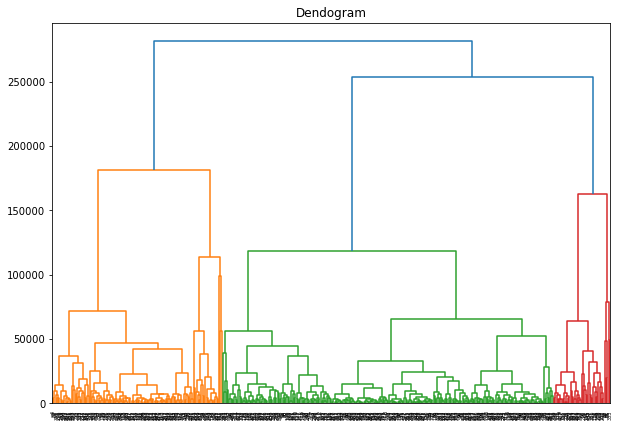

In [19]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Dendogram")  
dend = shc.dendrogram(shc.linkage(data,method='ward'))

In [20]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
cluster.fit_predict(data)

array([0, 0, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 3, 3, 3, 0, 0, 0, 3, 0, 3, 0,
       3, 0, 3, 3, 0, 3, 4, 1, 3, 0, 3, 3, 0, 0, 3, 0, 4, 1, 3, 3, 0, 4,
       0, 4, 4, 2, 0, 4, 0, 0, 1, 0, 3, 0, 4, 0, 3, 0, 0, 2, 0, 0, 0, 4,
       0, 3, 0, 0, 3, 3, 0, 3, 0, 3, 0, 4, 0, 0, 0, 0, 0, 3, 0, 2, 2, 1,
       0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 0, 0, 0, 4,
       0, 0, 3, 3, 3, 0, 0, 0, 3, 0, 3, 0, 3, 0, 1, 1, 3, 3, 0, 1, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 3, 4, 0, 0, 0, 3, 3, 0, 3, 0,
       0, 4, 0, 3, 0, 0, 0, 3, 3, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0,
       1, 0, 0, 0, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0, 3, 3, 0, 4, 0, 3, 3, 0,
       0, 0, 4, 4, 3, 0, 0, 4, 0, 0, 0, 4, 3, 4, 0, 0, 0, 0, 4, 3, 0, 0,
       3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 3, 0, 1, 3, 3,
       3, 0, 0, 0, 0, 3, 3, 0, 0, 4, 0, 3, 0, 3, 0, 0, 1, 1, 0, 0, 3, 0,
       0, 0, 4, 3, 0, 3, 0, 0, 0, 1, 0, 0, 3, 0, 0, 3, 0, 0, 1, 3, 1, 1,
       0, 3, 3, 1, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3,